# CTD, CDOM and Nitrate data from Cabled shallow profilers at Oregon Slope Base and Axial Base
OOI Data Labs Education Nuggets

_Written by Lori Garzio, Rutgers University_

_Disclaimer: data used in this example were downloaded on Feb 20, 2020. The file format and/or contents could have changed._

**Objective**: Demonstrate how to download data from multiple instruments on the cabled Shallow Profilers from the OOI system using the Machine-to-Machine (M2M) interface, downsample the dataset, and export as a .csv file.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

## 1. Request Data from OOINet

**Oregon Slope Base Shallow Profiler Mooring (RS01SBPS)**

**Axial Base Shallow Profiler Mooring (RS03AXPS)**
* CTD (dissolved oxygen is delivered in the CTD data stream)
    * Instruments: RS01SBPS-SF01A-2A-CTDPFA102, RS03AXPS-SF03A-2A-CTDPFA302
    * Data stream: ctdpf_sbe43_sample
    * Parameters: seawater_pressure, seawater_temperature, practical_salinity, corrected_dissolved_oxygen
* Fluorometer
    * Instruments: RS01SBPS-SF01A-3A-FLORTD101, RS03AXPS-SF03A-3A-FLORTD301
    * Data stream: flort_d_data_record
    * Parameter: fluorometric_cdom, int_ctd_pressure
* Nitrate sensor
    * Instruments: RS01SBPS-SF01A-4A-NUTNRA101, RS03AXPS-SF03A-4A-NUTNRA301
    * Data stream: nutnr_a_sample
    * Parameters: salinity_corrected_nitrate, int_ctd_pressure
* Time range: 2017-08-04 to 2017-12-10
* Delivery method: streamed

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/extras'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for this instrument. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# RS01SBPSctd_url = request_data('RS01SBPS-SF01A-2A-CTDPFA102', 'streamed', 'ctdpf_sbe43_sample',
#                                '2017-08-04T00:00:00.000Z', '2017-12-10T00:00:00.000Z')

# RS03AXPSctd_url = request_data('RS03AXPS-SF03A-2A-CTDPFA302', 'streamed', 'ctdpf_sbe43_sample',
#                                '2017-08-04T00:00:00.000Z', '2017-12-10T00:00:00.000Z')

# RS01SBPSfluor_url = request_data('RS01SBPS-SF01A-3A-FLORTD101', 'streamed', 'flort_d_data_record',
#                                  '2017-08-04T00:00:00.000Z', '2017-12-10T00:00:00.000Z')

# RS03AXPSfluor_url = request_data('RS03AXPS-SF03A-3A-FLORTD301', 'streamed', 'flort_d_data_record',
#                                  '2017-08-04T00:00:00.000Z', '2017-12-10T00:00:00.000Z')

# RS01SBPSnut_url = request_data('RS01SBPS-SF01A-4A-NUTNRA101', 'streamed', 'nutnr_a_sample',
#                                '2017-08-04T00:00:00.000Z', '2017-12-10T00:00:00.000Z')

# RS03AXPSnut_url = request_data('RS03AXPS-SF03A-4A-NUTNRA301', 'streamed', 'nutnr_a_sample',
#                                '2017-08-04T00:00:00.000Z', '2017-12-10T00:00:00.000Z')

# print('RS01SBPSctd_url = %s' %RS01SBPSctd_url)
# print('RS03AXPSctd_url = %s' %RS03AXPSctd_url)
# print('RS01SBPSfluor_url = %s' %RS01SBPSfluor_url)
# print('RS03AXPSfluor_url = %s' %RS03AXPSfluor_url)
# print('RS01SBPSnut_url = %s' %RS01SBPSnut_url)
# print('RS03AXPSnut_url = %s' %RS03AXPSnut_url)

## 2. Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the url must be surrounded by quotations. 

**Note**: this data request may take a while to fulfill because it's a very dense dataset. Later on we will calculate minute-averaged data to make the dataset more manageable.

In [5]:
RS01SBPSctd_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200220T181004402Z-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html'
RS03AXPSctd_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200220T181004920Z-RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample/catalog.html'
RS01SBPSfluor_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200220T181005286Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/catalog.html'
RS03AXPSfluor_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200220T181005667Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record/catalog.html'
RS01SBPSnut_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200220T181005985Z-RS01SBPS-SF01A-4A-NUTNRA101-streamed-nutnr_a_sample/catalog.html'
RS03AXPSnut_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200220T181006291Z-RS03AXPS-SF03A-4A-NUTNRA301-streamed-nutnr_a_sample/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files and removing collocated datasets (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets (such as these cabled datasets), but is also fine for working with smaller datasets.

In [6]:
def get_data(url, variables):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in vars:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

In [7]:
# Specify the variable(s) of interest and get the data from the datasets
CTD_vars = ['seawater_pressure', 'seawater_temperature', 'practical_salinity', 'corrected_dissolved_oxygen']
FLORT_vars = ['fluorometric_cdom', 'int_ctd_pressure']
NUTNR_vars = ['salinity_corrected_nitrate', 'int_ctd_pressure']

SBPSctd, SBPSctd_units = get_data(RS01SBPSctd_url, CTD_vars)
AXPSctd, AXPSctd_units = get_data(RS03AXPSctd_url, CTD_vars)
SBPSfluor, SBPSfluor_units = get_data(RS01SBPSfluor_url, FLORT_vars)
AXPSfluor, AXPSfluor_units = get_data(RS03AXPSfluor_url, FLORT_vars)
SBPSnut, SBPSnut_units = get_data(RS01SBPSnut_url, NUTNR_vars)
AXPSnut, AXPSnut_units = get_data(RS03AXPSnut_url, NUTNR_vars)
print(SBPSctd_units)
print(SBPSfluor_units)
print(AXPSnut_units)

{'seawater_pressure': ['dbar'], 'seawater_temperature': ['ºC'], 'practical_salinity': ['1'], 'corrected_dissolved_oxygen': ['µmol kg-1']}
{'fluorometric_cdom': ['ppb'], 'int_ctd_pressure': ['dbar']}
{'salinity_corrected_nitrate': ['µmol L-1'], 'int_ctd_pressure': ['dbar']}


In [8]:
# print the first few lines of the Oregon Slope Base                           datasets
SBPSctd.head()

,time,seawater_pressure,seawater_temperature,practical_salinity,corrected_dissolved_oxygen
3947201,2017-08-04 20:04:41.032162304,169.229658,7.856275,33.893052,77.223636
3947202,2017-08-04 20:04:42.032479232,169.318444,7.856338,33.892178,77.137924
3947203,2017-08-04 20:04:43.032590336,169.408299,7.856212,33.891277,76.975278
3947204,2017-08-04 20:04:44.032076288,169.499239,7.856023,33.890437,76.890024
3947205,2017-08-04 20:04:45.032080384,169.594458,7.855897,33.889113,76.843618


In [9]:
SBPSfluor.head()

,time,fluorometric_cdom,int_ctd_pressure
2713374,2017-08-04 20:00:40.496340992,2.2761,169.229658
2713375,2017-08-04 20:00:41.624306688,2.0232,169.229658
2713376,2017-08-04 20:00:42.752332800,2.2761,169.229658
2713377,2017-08-04 20:00:43.880345088,2.3604,169.229658
2713378,2017-08-04 20:00:45.008390656,2.1918,169.229658


In [10]:
SBPSnut.head()

,time,salinity_corrected_nitrate,int_ctd_pressure
0,2017-08-04 21:00:18.059724288,-0.265356,17.709219
1,2017-08-04 21:00:19.230814720,-0.429891,17.779454
2,2017-08-04 22:00:18.049122304,21.653149,85.689989
3,2017-08-04 22:00:19.221496832,21.615385,85.580815
4,2017-08-04 23:00:18.055174144,29.741616,169.784965


## Quick Data Plots
Make some quick plots of these datasets. First, we will calculate depth-binned (1 dbar) hourly averages to make the datasets more manageable using the function below, then we'll make profile plots of all the data to see if there are any datasets that need to be cleaned up.

In [11]:
def downsample(df, pressure_varname):
    # cut off the minutes and seconds in the time stamp
    df['time'] = df['time'].apply(lambda t: t.strftime('%Y-%m-%d %H'))

    # create a new column in the dataframe with pressure rounded to the nearest 1 dbar
    df['Pressure Bin (dbar)'] = (round(df[pressure_varname]))
    
    # create a new column in the dataframe with pressure rounded to the nearest 5 dbar
    # df['Pressure Bin (dbar)'] = (5 * round(df[pressure_varname]/5))

    # calculate depth-binned averages by time
    df_binned = df.groupby(['time', 'Pressure Bin (dbar)']).mean()
    return df_binned

In [12]:
SBPSctd_binned = downsample(SBPSctd, 'seawater_pressure')
SBPSctd_binned.head()

seawater_pressure  seawater_temperature  \
time          Pressure Bin (dbar)                                            
2017-08-04 20 17.0                         17.458275             12.829448   
              18.0                         17.863870             12.808050   
              19.0                         19.213297             12.523832   
              20.0                         20.130183             12.043226   
              21.0                         21.071782             11.654406   

                                   practical_salinity  \
time          Pressure Bin (dbar)                       
2017-08-04 20 17.0                          32.359242   
              18.0                          32.365248   
              19.0                          32.373257   
              20.0                          32.433667   
              21.0                          32.486471   

                                   corrected_dissolved_oxygen  
time          Pressure Bin (dbar)                              
2017-08-04 20 17.0                                 282.690070  
              18.0                                 282.511573  
              19.0                                 277.219623  
              20.0                                 276.976152  
              21.0                                 277.406571

This dataset now has 2 indices - 'time' and 'Pressure Bin (dbar)' - and they are on a different line in the dataframe from the rest of the headers. You can reset the indices so all of the headers are on the same line - it's not critical to do this, but makes the dataframe easier to look at. We'll do this for all of the resampled dataframes moving forward.

In [13]:
# reset the index
SBPSctd_binned = SBPSctd_binned.reset_index()
SBPSctd_binned.head()

,time,Pressure Bin (dbar),seawater_pressure,seawater_temperature,practical_salinity,corrected_dissolved_oxygen
0,2017-08-04 20,17.0,17.458275,12.829448,32.359242,282.690070
1,2017-08-04 20,18.0,17.863870,12.808050,32.365248,282.511573
2,2017-08-04 20,19.0,19.213297,12.523832,32.373257,277.219623
3,2017-08-04 20,20.0,20.130183,12.043226,32.433667,276.976152
4,2017-08-04 20,21.0,21.071782,11.654406,32.486471,277.406571


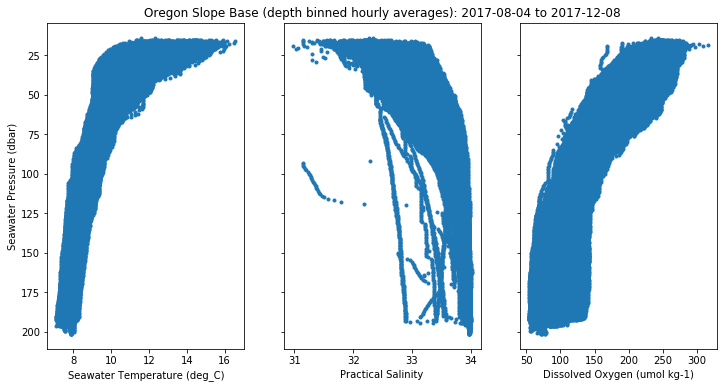

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 6))
ax1.plot(SBPSctd_binned['seawater_temperature'], SBPSctd_binned['seawater_pressure'], '.')
ax1.set_xlabel('Seawater Temperature (deg_C)')
ax1.set_ylabel('Seawater Pressure (dbar)')
ax2.plot(SBPSctd_binned['practical_salinity'], SBPSctd_binned['seawater_pressure'], '.')
ax2.set_xlabel('Practical Salinity')
ax3.plot(SBPSctd_binned['corrected_dissolved_oxygen'], SBPSctd_binned['seawater_pressure'], '.')
ax3.set_xlabel('Dissolved Oxygen (umol kg-1)')
ax3.invert_yaxis()
ax1.set_ylabel('Seawater Pressure (dbar)')
t0 = np.min(SBPSctd_binned['time']).split(' ')[0]
tf = np.max(SBPSctd_binned['time']).split(' ')[0]
ax2.set_title('Oregon Slope Base (depth binned hourly averages): {} to {}'.format(t0, tf));

In [15]:
AXPSctd_binned = downsample(AXPSctd, 'seawater_pressure')
AXPSctd_binned = AXPSctd_binned.reset_index()
AXPSctd_binned.head()

,time,Pressure Bin (dbar),seawater_pressure,seawater_temperature,practical_salinity,corrected_dissolved_oxygen
0,2017-08-04 00,147.0,147.343844,7.883738,33.803995,197.854833
1,2017-08-04 00,148.0,148.002678,7.886873,33.801982,197.368135
2,2017-08-04 00,149.0,148.995461,7.879786,33.806146,194.419083
3,2017-08-04 00,150.0,149.986531,7.871117,33.812278,191.802272
4,2017-08-04 00,151.0,150.981376,7.863111,33.817591,191.129918


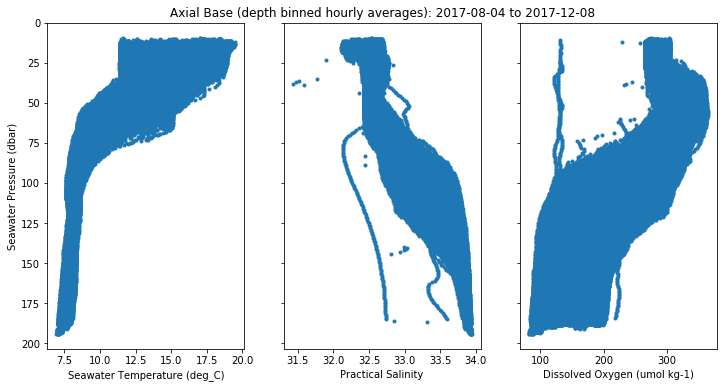

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 6))
ax1.plot(AXPSctd_binned['seawater_temperature'], AXPSctd_binned['seawater_pressure'], '.')
ax1.set_xlabel('Seawater Temperature (deg_C)')
ax1.set_ylabel('Seawater Pressure (dbar)')
ax2.plot(AXPSctd_binned['practical_salinity'], AXPSctd_binned['seawater_pressure'], '.')
ax2.set_xlabel('Practical Salinity')
ax3.plot(AXPSctd_binned['corrected_dissolved_oxygen'], AXPSctd_binned['seawater_pressure'], '.')
ax3.set_xlabel('Dissolved Oxygen (umol kg-1)')
ax3.invert_yaxis()
ax1.set_ylabel('Seawater Pressure (dbar)')
t0 = np.min(AXPSctd_binned['time']).split(' ')[0]
tf = np.max(AXPSctd_binned['time']).split(' ')[0]
ax2.set_title('Axial Base (depth binned hourly averages): {} to {}'.format(t0, tf));

It looks like there are some suspect data in this dataset. Let's get rid of the salinity values less than 32 using the function below:

In [17]:
def remove_values(df, varname, sign, value):
    cname = varname + '_ind'
    if sign == 'lessthan':
        df[cname] = df[varname] > value
    elif sign == 'greaterthan':
        df[cname] = df[varname] < value
    df = df.loc[df[cname] == True]
    df = df.drop(columns=[cname])
    return df

In [18]:
AXPSctd_binned = remove_values(AXPSctd_binned, 'practical_salinity', 'lessthan', 32)

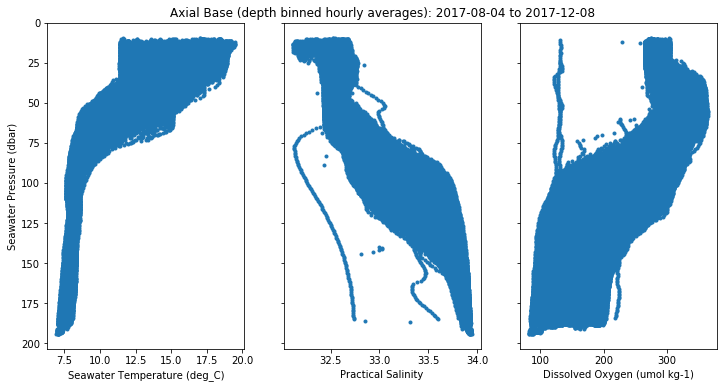

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 6))
ax1.plot(AXPSctd_binned['seawater_temperature'], AXPSctd_binned['seawater_pressure'], '.')
ax1.set_xlabel('Seawater Temperature (deg_C)')
ax1.set_ylabel('Seawater Pressure (dbar)')
ax2.plot(AXPSctd_binned['practical_salinity'], AXPSctd_binned['seawater_pressure'], '.')
ax2.set_xlabel('Practical Salinity')
ax3.plot(AXPSctd_binned['corrected_dissolved_oxygen'], AXPSctd_binned['seawater_pressure'], '.')
ax3.set_xlabel('Dissolved Oxygen (umol kg-1)')
ax3.invert_yaxis()
ax1.set_ylabel('Seawater Pressure (dbar)')
t0 = np.min(AXPSctd_binned['time']).split(' ')[0]
tf = np.max(AXPSctd_binned['time']).split(' ')[0]
ax2.set_title('Axial Base (depth binned hourly averages): {} to {}'.format(t0, tf));

In [20]:
# Repeat for the fluorometer and nitrate datasets. This downsampling will take several minutes.
SBPSfluor_binned = downsample(SBPSfluor, 'int_ctd_pressure')
SBPSfluor_binned = SBPSfluor_binned.reset_index()
AXPSfluor_binned = downsample(AXPSfluor, 'int_ctd_pressure')
AXPSfluor_binned = AXPSfluor_binned.reset_index()
SBPSnut_binned = downsample(SBPSnut, 'int_ctd_pressure')
SBPSnut_binned = SBPSnut_binned.reset_index()
AXPSnut_binned = downsample(AXPSnut, 'int_ctd_pressure')
AXPSnut_binned = AXPSnut_binned.reset_index();

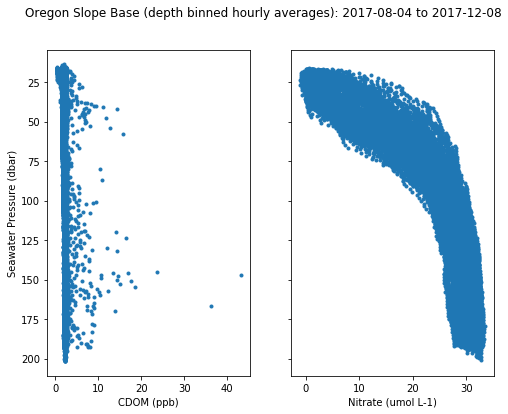

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 6))
ax1.plot(SBPSfluor_binned['fluorometric_cdom'], SBPSfluor_binned['int_ctd_pressure'], '.')
ax1.set_xlabel('CDOM (ppb)')
ax1.set_ylabel('Seawater Pressure (dbar)')
ax2.plot(SBPSnut_binned['salinity_corrected_nitrate'], SBPSnut_binned['int_ctd_pressure'], '.')
ax2.set_xlabel('Nitrate (umol L-1)')
ax2.invert_yaxis()
ax1.set_ylabel('Seawater Pressure (dbar)')
t0 = np.min(SBPSfluor_binned['time']).split(' ')[0]
tf = np.max(SBPSfluor_binned['time']).split(' ')[0]
fig.suptitle('Oregon Slope Base (depth binned hourly averages): {} to {}'.format(t0, tf));

Let's remove the scattering of noisy Oregon Slope CDOM data.

In [22]:
SBPSfluor_binned = remove_values(SBPSfluor_binned, 'fluorometric_cdom', 'greaterthan', 3)

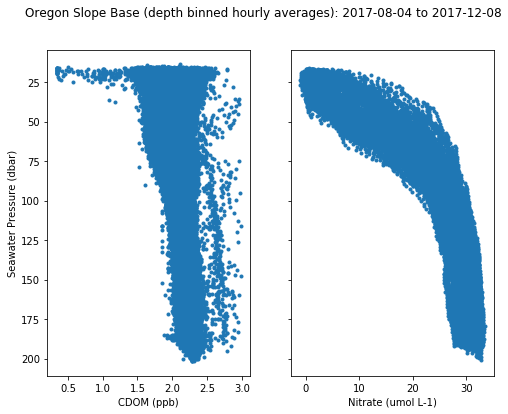

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 6))
ax1.plot(SBPSfluor_binned['fluorometric_cdom'], SBPSfluor_binned['int_ctd_pressure'], '.')
ax1.set_xlabel('CDOM (ppb)')
ax1.set_ylabel('Seawater Pressure (dbar)')
ax2.plot(SBPSnut_binned['salinity_corrected_nitrate'], SBPSnut_binned['int_ctd_pressure'], '.')
ax2.set_xlabel('Nitrate (umol L-1)')
ax2.invert_yaxis()
ax1.set_ylabel('Seawater Pressure (dbar)')
t0 = np.min(SBPSfluor_binned['time']).split(' ')[0]
tf = np.max(SBPSfluor_binned['time']).split(' ')[0]
fig.suptitle('Oregon Slope Base (depth binned hourly averages): {} to {}'.format(t0, tf));

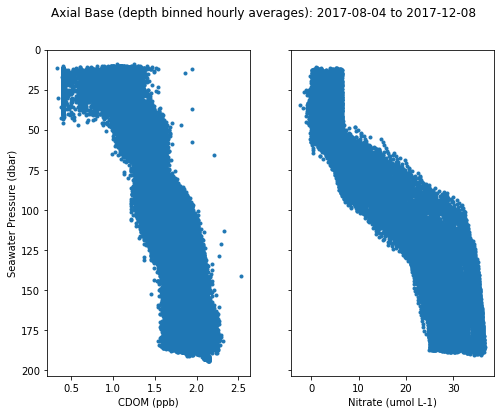

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 6))
ax1.plot(AXPSfluor_binned['fluorometric_cdom'], AXPSfluor_binned['int_ctd_pressure'], '.')
ax1.set_xlabel('CDOM (ppb)')
ax1.set_ylabel('Seawater Pressure (dbar)')
ax2.plot(AXPSnut_binned['salinity_corrected_nitrate'], AXPSnut_binned['int_ctd_pressure'], '.')
ax2.set_xlabel('Nitrate (umol L-1)')
ax2.invert_yaxis()
ax1.set_ylabel('Seawater Pressure (dbar)')
t0 = np.min(AXPSfluor_binned['time']).split(' ')[0]
tf = np.max(AXPSfluor_binned['time']).split(' ')[0]
fig.suptitle('Axial Base (depth binned hourly averages): {} to {}'.format(t0, tf));

Now that we have the data downsampled and removed outliers, let's merge the dataframes into 2 dataframes (one for each profiler) and make some cross-section plots. You can only merge 2 dataframes at a time, so we will have to do it twice for each profiler.

In [30]:
SBPSdf = pd.merge(SBPSctd_binned, SBPSfluor_binned, on=['time', 'Pressure Bin (dbar)'], how='outer')
SBPSdf = pd.merge(SBPSdf, SBPSnut_binned, on=['time', 'Pressure Bin (dbar)'], how='outer')
SBPSdf.head()

,time,Pressure Bin (dbar),seawater_pressure,seawater_temperature,practical_salinity,corrected_dissolved_oxygen,fluorometric_cdom,int_ctd_pressure_x,salinity_corrected_nitrate,int_ctd_pressure_y
0,2017-08-04 20,17.0,17.458275,12.829448,32.359242,282.690070,1.854600,17.457615,NaN,NaN
1,2017-08-04 20,18.0,17.863870,12.808050,32.365248,282.511573,1.748842,17.855085,NaN,NaN
2,2017-08-04 20,19.0,19.213297,12.523832,32.373257,277.219623,1.594036,19.203394,NaN,NaN
3,2017-08-04 20,20.0,20.130183,12.043226,32.433667,276.976152,1.695367,20.112746,NaN,NaN
4,2017-08-04 20,21.0,21.071782,11.654406,32.486471,277.406571,1.778730,21.022836,NaN,NaN


We don't need seawater_pressure or int_ctd_pressure data anymore since we have the Pressure Bin, so let's drop those from the final dataframe, and round the data.

In [31]:
SBPSdf = SBPSdf.drop(columns=['seawater_pressure', 'int_ctd_pressure_x', 'int_ctd_pressure_y'])

# round values
SBPSdf = SBPSdf.round({'seawater_temperature': 2, 
                       'practical_salinity': 2,
                       'corrected_dissolved_oxygen': 2,
                       'fluorometric_cdom': 2,
                       'salinity_corrected_nitrate': 2})

SBPSdf.head()

,time,Pressure Bin (dbar),seawater_temperature,practical_salinity,corrected_dissolved_oxygen,fluorometric_cdom,salinity_corrected_nitrate
0,2017-08-04 20,17.0,12.83,32.36,282.69,1.85,NaN
1,2017-08-04 20,18.0,12.81,32.37,282.51,1.75,NaN
2,2017-08-04 20,19.0,12.52,32.37,277.22,1.59,NaN
3,2017-08-04 20,20.0,12.04,32.43,276.98,1.70,NaN
4,2017-08-04 20,21.0,11.65,32.49,277.41,1.78,NaN


In [32]:
# make sure the timestamps and pressure bins are in ascending order
SBPSdf.sort_values(by=['time', 'Pressure Bin (dbar)'], inplace=True)

# rename and add units to the columns
SBPSdf = SBPSdf.rename(columns={'seawater_temperature': 'Seawater Temperature (deg_C)',
                               'practical_salinity': 'Practical Salinity',
                               'corrected_dissolved_oxygen': 'Dissolved Oxygen (umol kg-1)',
                               'fluorometric_cdom': 'CDOM (ppb)',
                               'salinity_corrected_nitrate': 'Nitrate (µmol L-1)'})
# convert time from a object to a datetime
SBPSdf['time'] = SBPSdf['time'].apply(lambda t: dt.datetime.strptime(t, '%Y-%m-%d %H'))

SBPSdf.head()

,time,Pressure Bin (dbar),Seawater Temperature (deg_C),Practical Salinity,Dissolved Oxygen (umol kg-1),CDOM (ppb),Nitrate (µmol L-1)
0,2017-08-04 20:00:00,17.0,12.83,32.36,282.69,1.85,NaN
1,2017-08-04 20:00:00,18.0,12.81,32.37,282.51,1.75,NaN
2,2017-08-04 20:00:00,19.0,12.52,32.37,277.22,1.59,NaN
3,2017-08-04 20:00:00,20.0,12.04,32.43,276.98,1.70,NaN
4,2017-08-04 20:00:00,21.0,11.65,32.49,277.41,1.78,NaN


Do the same thing for the Axial Base profiler.

In [33]:
AXPSdf = pd.merge(AXPSctd_binned, AXPSfluor_binned, on=['time', 'Pressure Bin (dbar)'], how='outer')
AXPSdf = pd.merge(AXPSdf, AXPSnut_binned, on=['time', 'Pressure Bin (dbar)'], how='outer')
AXPSdf.head()
AXPSdf = AXPSdf.drop(columns=['seawater_pressure', 'int_ctd_pressure_x', 'int_ctd_pressure_y'])

# round values
AXPSdf = AXPSdf.round({'seawater_temperature': 2, 
                       'practical_salinity': 2,
                       'corrected_dissolved_oxygen': 2,
                       'fluorometric_cdom': 2,
                       'salinity_corrected_nitrate': 2})

# make sure the timestamps and pressure bins are in ascending order
AXPSdf.sort_values(by=['time', 'Pressure Bin (dbar)'], inplace=True) 

# rename and add units to the columns
AXPSdf = AXPSdf.rename(columns={'seawater_temperature': 'Seawater Temperature (deg_C)',
                               'practical_salinity': 'Practical Salinity',
                               'corrected_dissolved_oxygen': 'Dissolved Oxygen (umol kg-1)',
                               'fluorometric_cdom': 'CDOM (ppb)',
                               'salinity_corrected_nitrate': 'Nitrate (µmol L-1)'})
# convert time from a object to a datetime
AXPSdf['time'] = AXPSdf['time'].apply(lambda t: dt.datetime.strptime(t, '%Y-%m-%d %H'))

AXPSdf.head()

,time,Pressure Bin (dbar),Seawater Temperature (deg_C),Practical Salinity,Dissolved Oxygen (umol kg-1),CDOM (ppb),Nitrate (µmol L-1)
0,2017-08-04,147.0,7.88,33.80,197.85,1.62,NaN
1,2017-08-04,148.0,7.89,33.80,197.37,1.69,NaN
2,2017-08-04,149.0,7.88,33.81,194.42,1.74,NaN
3,2017-08-04,150.0,7.87,33.81,191.80,1.74,NaN
4,2017-08-04,151.0,7.86,33.82,191.13,1.74,NaN


## 3. Cross-section plots and export to csv
Make some more informative plots, and export the datasets to csv files. The plotting takes several minutes.

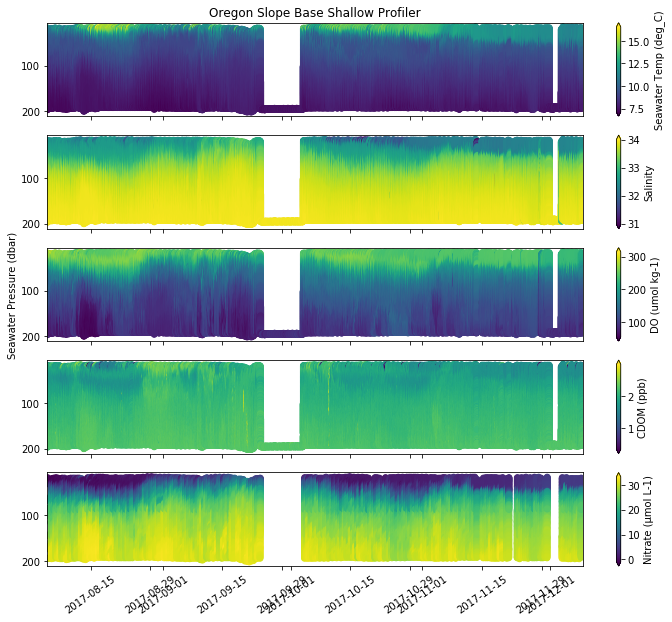

In [34]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, figsize=(12, 10))
xc1 = ax1.scatter(np.array(SBPSdf['time']), SBPSdf['Pressure Bin (dbar)'], c=SBPSdf['Seawater Temperature (deg_C)'])
ax1.invert_yaxis()
ax1.set_xlabel('')
ax1.set_ylabel('')
bar1 = fig.colorbar(xc1, ax=ax1, label='Seawater Temp (deg_C)', extend='both')
ax1.set_title('Oregon Slope Base Shallow Profiler')

xc2 = ax2.scatter(np.array(SBPSdf['time']), SBPSdf['Pressure Bin (dbar)'], c=SBPSdf['Practical Salinity'])
ax2.invert_yaxis()
ax2.set_xlabel('')
ax2.set_ylabel('')
bar2 = fig.colorbar(xc2, ax=ax2, label='Salinity', extend='both')

xc3 = ax3.scatter(np.array(SBPSdf['time']), SBPSdf['Pressure Bin (dbar)'], c=SBPSdf['Dissolved Oxygen (umol kg-1)'])
ax3.invert_yaxis()
ax3.set_xlabel('')
ax3.set_ylabel('Seawater Pressure (dbar)')
bar3 = fig.colorbar(xc3, ax=ax3, label='DO (umol kg-1)', extend='both')

xc4 = ax4.scatter(np.array(SBPSdf['time']), SBPSdf['Pressure Bin (dbar)'], c=SBPSdf['CDOM (ppb)'])
ax4.invert_yaxis()
ax4.set_xlabel('')
ax4.set_ylabel('')
bar4 = fig.colorbar(xc4, ax=ax4, label='CDOM (ppb)', extend='both')

xc5 = ax5.scatter(np.array(SBPSdf['time']), SBPSdf['Pressure Bin (dbar)'], c=SBPSdf['Nitrate (µmol L-1)'])
ax5.invert_yaxis()
ax5.set_xlabel('')
ax5.set_ylabel('')
bar5 = fig.colorbar(xc5, ax=ax5, label='Nitrate (µmol L-1)', extend='both')

# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(SBPSdf['time']), np.nanmax(SBPSdf['time'])])

# rotate x tick labels
plt.xticks(rotation=35);

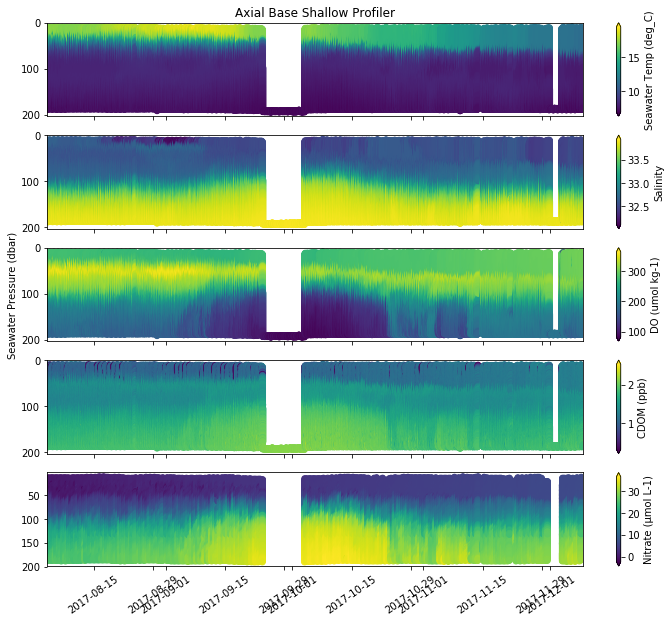

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, figsize=(12, 10))
xc1 = ax1.scatter(np.array(AXPSdf['time']), AXPSdf['Pressure Bin (dbar)'], c=AXPSdf['Seawater Temperature (deg_C)'])
ax1.invert_yaxis()
ax1.set_xlabel('')
ax1.set_ylabel('')
bar1 = fig.colorbar(xc1, ax=ax1, label='Seawater Temp (deg_C)', extend='both')
ax1.set_title('Axial Base Shallow Profiler')

xc2 = ax2.scatter(np.array(AXPSdf['time']), AXPSdf['Pressure Bin (dbar)'], c=AXPSdf['Practical Salinity'])
ax2.invert_yaxis()
ax2.set_xlabel('')
ax2.set_ylabel('')
bar2 = fig.colorbar(xc2, ax=ax2, label='Salinity', extend='both')

xc3 = ax3.scatter(np.array(AXPSdf['time']), AXPSdf['Pressure Bin (dbar)'], c=AXPSdf['Dissolved Oxygen (umol kg-1)'])
ax3.invert_yaxis()
ax3.set_xlabel('')
ax3.set_ylabel('Seawater Pressure (dbar)')
bar3 = fig.colorbar(xc3, ax=ax3, label='DO (umol kg-1)', extend='both')

xc4 = ax4.scatter(np.array(AXPSdf['time']), AXPSdf['Pressure Bin (dbar)'], c=AXPSdf['CDOM (ppb)'])
ax4.invert_yaxis()
ax4.set_xlabel('')
ax4.set_ylabel('')
bar4 = fig.colorbar(xc4, ax=ax4, label='CDOM (ppb)', extend='both')

xc5 = ax5.scatter(np.array(AXPSdf['time']), AXPSdf['Pressure Bin (dbar)'], c=AXPSdf['Nitrate (µmol L-1)'])
ax5.invert_yaxis()
ax5.set_xlabel('')
ax5.set_ylabel('')
bar5 = fig.colorbar(xc5, ax=ax5, label='Nitrate (µmol L-1)', extend='both')

# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(AXPSdf['time']), np.nanmax(AXPSdf['time'])])

# rotate x tick labels
plt.xticks(rotation=35);

In [37]:
SBPSdf.to_csv(os.path.join(save_dir, 'E01_RS01SBPS_Oregon_Slope_Base_profiler.csv'), index=False)
AXPSdf.to_csv(os.path.join(save_dir, 'E01_RS03AXPS_Axial_Base_profiler.csv'), index=False)